# TP Vocodeur de Phase

$\textit{DESVALL\'EES Henri}$

$\textit{LALAY Louis}$

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from soundfile import read

## 1.1 Généralités sur la TFCT

### Définition en convention passe bas

$$
\hat{X}_0(f,b) = \sum_{n\in \mathcal{Z}} x(n)w(n-b)e^{-2i\pi f n}
$$

Produit de convolution :

$$
(x*y)(m) = \sum_{n \in \mathcal{Z}} x(n)y(m-n)
$$

En considérant $f = f_0$ comme une constante, on a :
\begin{align*}
    \hat{X}_0(b) &= \sum_{n\in \mathcal{Z}} x(n)w(n-b)e^{-2i\pi f_0 n}\\
    &=e^{-2i\pi f_0 b} \sum_{n\in \mathcal{Z}} x(n)w_-(b-n)e^{2i\pi f_0 (b-n)}\\
    &= e^{-2i\pi f_0 b}(x*g)(b)
\end{align*}
Avec $g(n) = w_-(n)e^{2i\pi f_0 n}$ et $w_-(n) = w(-n)$.

Si on calcule la TFTC de $g$, on a :

\begin{align*}
TFTC[g](\nu) &= G(\nu)\\
&= \sum_{n \in \mathcal{Z}} w(-n)e^{2i\pi f_0 n}e^{-2i\pi \nu n}\\
&=\sum_{n \in \mathcal{Z}} w(-n)e^{-2i\pi (\nu-f_0) n}
\end{align*}

On pose le changement de variable $\nu_2 = f_0 - \nu$

\begin{align*}
G(\nu) &=\sum_{n \in \mathcal{Z}} w(-n)e^{2i\pi \nu_2 n}
\end{align*}

On pose le changement de variable  $n_2 = -n$

\begin{align*}
G(\nu) &=\sum_{n_2 \in \mathcal{Z}} w(n_2)e^{-2i\pi \nu_2 n_2}
\end{align*}

Finalement, $G(\nu) = W(f_0-\nu)$. 


En terme de filtrage, on peut voir la STFT comme un filtrage par un filtre ayant comme fonction de transfert $W(f_0-\nu)$ et modulé par $e^{-2i\pi f_0 b}$.

### Définition en convention passe bande

$$
\hat{X}_{loc}(f,b) = \sum_{n\in \mathcal{Z}} x(n+b)w(n)e^{-2i\pi f n}
$$

On pose le changement de variable $n_1 = n+b$ :
\begin{align*}
    \hat{X}_{loc}(f,b) &= \sum_{n_1\in \mathcal{Z}} x(n_1)w(n_1-b)e^{-2i\pi f (n_1-b)}\\
    &=e^{2i\pi f b}\sum_{n_1\in \mathcal{Z}} x(n_1)w(n_1-b)e^{-2i\pi f n_1}\\
    &=e^{2i\pi f b}\hat{X}_0(f,b)\\
    &= (x*g)(b)
\end{align*}

Pour l'implémentation numérique, on prend une tranche de signal que l'on multiplie avec la fenêtre. Cela correspond à l'approche passe-bande.

In [18]:
def stft(signal, /, window, Nfft=1024, hop_size=32):
    window_len = len(window)
    n_step = (len(signal) - window_len) // hop_size
    stft = np.zeros((Nfft, n_step), dtype=np.complex_)
    for k in range(n_step):
        frame = signal[k * hop_size : k * hop_size + window_len] * window
        stft[:, k] = np.fft.fft(frame, Nfft)
    return stft

## 1.2 Overlap-add reconstruction

### Condition de reconstruction parfaite 

On utilisera les notations suivantes : 
- $N_t$ : Nombre de fenêtres temporelles
- $R$ : Hop size
- $N$ : Taille des fenêtres
- $M$ : Taille de la FFT
- $w_a$ : Fenêtre de calcul de la STFT
- $w_s$ : Fenêtre de reconstruction
$$
y_w(n, u)=\frac{1}{N}\sum_{k=0}^{N-1}STFT(u,k)e^{2i\pi\frac{k}{M}(n)}
$$

On part de la définition du signal reconstruit pour trouver une condition sur les fenêtres.

\begin{align*}
y(n)&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R)y_w(n-u*R, u)\\
&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R)\frac{1}{N}\sum_{k=0}^{N-1}STFT(u,k)e^{2i\pi\frac{k}{M}(n-u\cdot R)}\\
&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R)\frac{1}{N}\sum_{k=0}^{N-1}  \sum_{m=0}^{N-1} w_a(m)x(m+u\cdot R)    e^{2i\pi\frac{k}{M}(n-u\cdot R-m)}\\
&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R) \sum_{m=0}^{N-1} w_a(m)x(m+u\cdot R)  \frac{1}{N}\sum_{k=0}^{N-1}  e^{2i\pi\frac{k}{M}(n-u\cdot R-m)}\\
\end{align*}

Ici il faut remarquer que $\frac{1}{N}\sum_{k=0}^{N-1}  e^{2i\pi\frac{k}{M}(n-u\cdot R-m)} = {\huge \bf1}_{n-m-u\cdot R} $ qui vaut 1 quand $m=n-u\cdot R$ et 0 sinon. On substitue donc dans l'équation précédente :

\begin{align*}
y(n)&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R) \sum_{m=0}^{N-1} w_a(m)x(m+u\cdot R)  {\huge \bf1}_{n-m-u\cdot R}\\
&=\sum_{u=0}^{N_t-1}w_s(n - u\cdot R) w_a(n-u\cdot R)x(n)\\
&=x(n)\sum_{u=0}^{N_t-1}w_s(n - u\cdot R) w_a(n-u\cdot R)
\end{align*}

On retrouve bien la condition portant sur le Complete Overlap ADD :
$$
\sum_{u=0}^{N_t-1}w_s(n - u\cdot R) w_a(n-u\cdot R)=1
$$

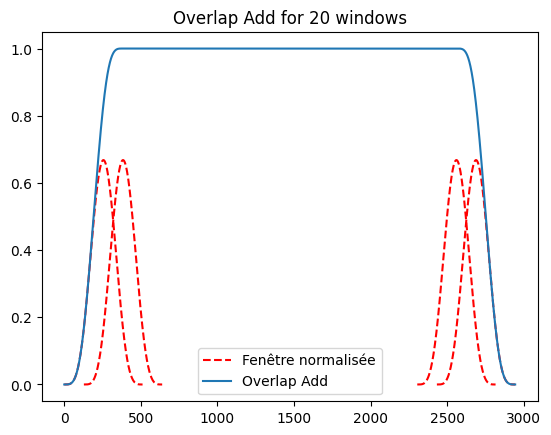

In [38]:
def ola(window, hop_size, n = 20, show=True):
    if n<4:
        n=4
    window_len = len(window)
    ola_out = np.zeros(hop_size * (n - 1) + window_len)
    for k in range(n):
        ola_out[k * hop_size : k * hop_size + window_len] += window
    if show:
        plt.figure()
        plt.plot(window, "--r")
        plt.plot(
            np.arange(hop_size, hop_size + window_len),
            window,
            "--r",
        )
        plt.plot(
            np.arange(hop_size * (n - 2), hop_size * (n - 2) + window_len),
            window,
            "--r",
        )
        plt.plot(
            np.arange(hop_size * (n - 1), hop_size * (n - 1) + window_len),
            window,
            "--r",
            label="Fenêtre normalisée",
        )
        plt.plot(ola_out, label="Overlap Add")
        plt.title(f"Overlap Add for {n} windows")
        plt.legend()
        plt.show()
    return ola_out


## Overlap Add pour une fenêtre de STFT égale à la fenêtre de reconstruction
window = np.hanning(512)
hop_size = 128
norm = np.sum(window**2) / hop_size
_ = ola(window * window / norm, hop_size)

## Resynthèse

### Egaliseur Audio

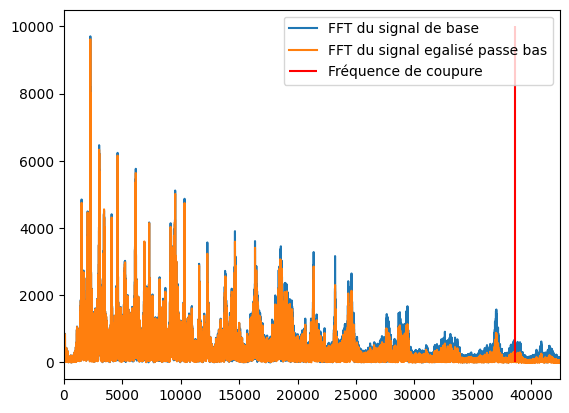

In [60]:
def egaliseur(stft, window, hop_size, weights):
    Nw = len(window)
    M, Nt = stft.shape
    if len(weights)!=M:
        print(f"Erreur sur les poids : la FFT est de taille {M=} alors que les poids sont de taille {len(weights)=}")
        return 
    out = np.zeros(Nt * hop_size + Nw)
    for k in range(Nt):
        deb = k*hop_size
        fin = deb + Nw
        out[deb:fin] += window*np.fft.ifft(stft[:,k]*weights, M)[:Nw].real
    return out


signal, fs = read('song.wav')
signal_len = signal.shape[0]
window_len = 64
window = np.hanning(window_len)
hop_size = window_len//4
Nfft = window_len

poids_passe_bas = np.ones(Nfft)
f_coupure = Nfft//30
ind_f_coupure = int(f_coupure/Nfft*signal_len)
poids_passe_bas[f_coupure:-f_coupure]=0

Xtilde = stft(signal, window = window, hop_size=hop_size, Nfft=Nfft)
signal_egal = egaliseur(Xtilde, window/norm, hop_size, poids_passe_bas)

plt.plot(np.abs(np.fft.fft(signal)), label = "FFT du signal de base")
plt.plot(np.abs(np.fft.fft(signal_egal)), label = "FFT du signal egalisé passe bas")
plt.vlines(ind_f_coupure, 0, 10000, colors='r', label = "Fréquence de coupure")
plt.xlim((0,ind_f_coupure+ind_f_coupure//10))
plt.legend()
plt.show()